In [1]:
%load_ext autoreload
%autoreload 2

from celeste_rl.level import *
from celeste_rl.env import *
from celeste_rl.models import *
from rtgym import DEFAULT_CONFIG_DICT
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import PPO
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import cv2
import gymnasium

In [17]:
import zmq
import numpy as np
import matplotlib.pyplot as plt
import cv2

import PIL.Image as Image
import io
import json
import base64

context = zmq.Context()
socket = context.socket(zmq.REQ)
socket.connect("tcp://localhost:7777")

socket.send_string(json.dumps([1]))
test = socket.recv()



In [18]:
uh = json.loads(test)[0]

In [19]:
img = np.array(Image.open(io.BytesIO(base64.b64decode(uh))))[..., :3]

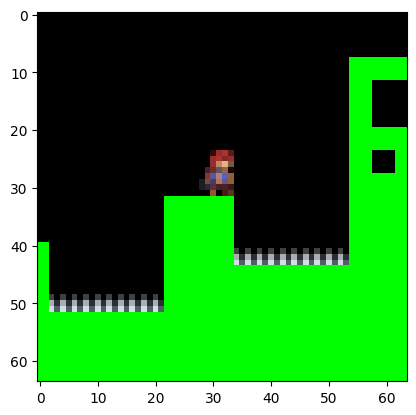

In [20]:
plt.imshow(img)

In [8]:
from celeste_rl.env_gym import CelesteImgGym

In [9]:
env = CelesteImgGym()


In [ ]:
l = list(test)



fk = np.array(l).reshape((180,320,4))



fk.dtype

resized = cv2.resize(fk.astype(np.uint8), (64,64), cv2.INTER_LANCZOS4)

plt.imshow(resized)

plt.imshow(fk)

In [ ]:
320*180*4

In [ ]:
b

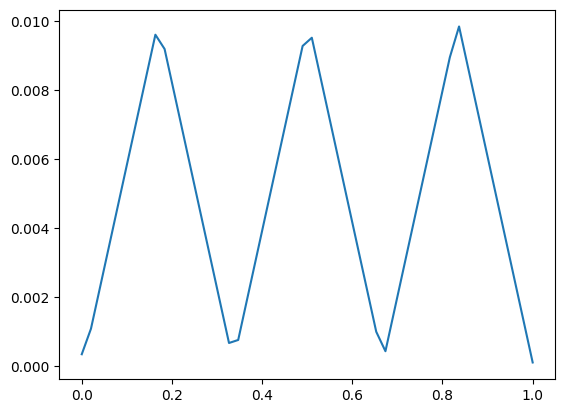

In [61]:
cyclic_schedule = CyclicLR(step_size=0.166)
ys = []
xs = np.linspace(0, 1)
ys = [cyclic_schedule.adapted_clr(x) for x in xs] 
plt.plot(xs,ys)

In [2]:
from pytorch_grad_cam import EigenCAM, EigenGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [3]:
my_config = DEFAULT_CONFIG_DICT
my_config["interface"] = CelesteGym
my_config["time_step_duration"] = 0.06
my_config["start_obs_capture"] = 0.06
my_config["time_step_timeout_factor"] = 1.0
my_config["ep_max_length"] = 1_000_000
my_config["act_buf_len"] = 20
my_config["reset_act_buf"] = False
my_config["benchmark"] = True
my_config["benchmark_polyak"] = 0.2

env = gymnasium.make("real-time-gym-v1", config=my_config)

wrapenv = Monitor(FlattenerEnv(env))
model = PPO("MultiInputPolicy",
            wrapenv,
            n_steps=256,
            learning_rate=5e-3,
            policy_kwargs=dict(normalize_images=False,
                              features_extractor_class=CustomCombinedExtractor),
            verbose=1,
            device='cpu',
            tensorboard_log="./celeste_tensorboard/")

/home/leopaul/mambaforge/envs/zmq/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:29: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/home/leopaul/mambaforge/envs/zmq/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:34: UserWarning: WARN: It seems a Box observation space is an image but the lower and upper bounds are not [0, 255]. Actual lower bound: 0.0, upper bound: 1.0. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(
/home/leopaul/mambaforge/envs/zmq/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.war

Using cpu device
Wrapping the env in a DummyVecEnv.


In [ ]:
# testmodel = model.policy.features_extractor.extractors.image
# cam = EigenCAM(testmodel, [testmodel.cnn[0]])

# img = wrapenv.step(np.array([0,0,0,0,0,0,0]))[0]['image']
# input_tensor = th.tensor(img, dtype=th.float)[None, ...]
# cam_out = cam(input_tensor)
# rgb = LevelRenderer.cm(LevelRenderer.norm(img[0] + img.argmax(0)))

# plt.imshow(show_cam_on_image(rgb[:,:,:3], cam_out[0], use_rgb=True))

In [22]:
context = zmq.Context()
socket = context.socket(zmq.REQ)
socket.connect("tcp://localhost:7777")
initialized = True



In [ ]:
# %%timeit -n 1000 
# fullinp = th.cat([torch_obs['image'][:, [i,LevelRenderer.ID_MAP['Player']]] for i in range(LevelRenderer.max_idx+1) if i != LevelRenderer.ID_MAP['Player']], dim=1)

In [5]:
# %%prun -D learning.prof

# vec_env = model.get_env()
# obs = vec_env.reset()
# for i in range(1000):
#     action, _state = model.predict(obs, deterministic=True)
#     obs, reward, done, info = vec_env.step(action)

In [24]:
# In[10]:

my_config = DEFAULT_CONFIG_DICT
my_config["interface"] = CelesteGym
my_config["time_step_duration"] = 0.04
my_config["start_obs_capture"] = 0.04
my_config["time_step_timeout_factor"] = 1.0
my_config["ep_max_length"] = 1_000_000
my_config["act_buf_len"] = 4
my_config["reset_act_buf"] = False
my_config["benchmark"] = True
my_config["benchmark_polyak"] = 0.2

run = wandb.init(
    project="celesterl",
    config=my_config,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)

env = gymnasium.make("real-time-gym-v1", config=my_config)

wrapenv = Monitor(FlattenerEnv(env))
model = PPO("MultiInputPolicy",
            wrapenv,
            n_steps=2048,
            learning_rate=5e-3,
            policy_kwargs=dict(normalize_images=False,
                              features_extractor_class=CustomCombinedExtractor),
            verbose=1,
            device='cpu',
            tensorboard_log="./celeste_tensorboard/")

for i in range(10):

    model.learn(100_000)
    
    model.save(f'model2_{i}.sav')



wandb: Currently logged in as: boesingerl. Use `wandb login --relogin` to force relogin


/home/leopaul/mambaforge/envs/zmq/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:29: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/home/leopaul/mambaforge/envs/zmq/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:34: UserWarning: WARN: It seems a Box observation space is an image but the lower and upper bounds are not [0, 255]. Actual lower bound: 0.0, upper bound: 1.0. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(
/home/leopaul/mambaforge/envs/zmq/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.war

Using cpu device
Wrapping the env in a DummyVecEnv.


Logging to ./celeste_tensorboard/PPO_41


/home/leopaul/mambaforge/envs/zmq/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/leopaul/mambaforge/envs/zmq/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:164: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/leopaul/mambaforge/envs/zmq/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/leopaul/mambaforge/envs/zmq/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:164: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type:

KeyboardInterrupt: 